<a href="https://colab.research.google.com/github/Hosna84/Absolute-ajority/blob/main/financial_text_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
    Machine learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2025<br>
<font color=3C99D size=5>
      Financial Text Sentiment Analysis
</div>
<div dir=ltr align=center>
<font color=0CBCDF size=4>
    Faraz Doagooye Tehrani, Amir Parsa Safari, Hosna Shahheidari
<br>
<font color=0CBCDF size=4>
</div>

____

# PART ONE

---

<font color=FF8C00 size=6>
Attention </font>

Set the colab boolean in the cell below to True if you are using google colab.

In [3]:
colab = True

In [4]:
import zipfile
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import math
from transformers import BertTokenizer
import copy

In [5]:
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
if colab:
    zip_path = '/content/drive/MyDrive/data/FinancialPhraseBank-v1.0.zip'
    extract_path = '/content/financial_data/FinancialPhraseBank-v1.0/'
else:
    zip_path = 'FinancialPhraseBank-v1.0.zip'
    extract_path = 'financial_data/'

if not os.path.exists(extract_path):
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Files extracted successfully!")
    else:
        print(f"Error: {zip_path} not found! Please move the zip file to: {os.getcwd()}")

data_file_allagree = os.path.join(extract_path , 'FinancialPhraseBank-v1.0/Sentences_AllAgree.txt')
df_allagree = pd.read_csv(data_file_allagree, sep='@', names=['sentence', 'label'], encoding='ISO-8859-1')

print(f"Data ready! Total rows of all agree: {len(df_allagree)}")
df_allagree.head()

Files extracted successfully!
Data ready! Total rows of all agree: 2264


,sentence,label
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive


In [7]:
data_file_75agree = os.path.join(extract_path, 'FinancialPhraseBank-v1.0/Sentences_75Agree.txt')
df_75agree = pd.read_csv(data_file_75agree, sep='@', names=['sentence', 'label'], encoding='ISO-8859-1')
data_file_66agree = os.path.join(extract_path, 'FinancialPhraseBank-v1.0/Sentences_66Agree.txt')
df_66agree = pd.read_csv(data_file_66agree, sep='@', names=['sentence', 'label'], encoding='ISO-8859-1')
data_file_50agree = os.path.join(extract_path, 'FinancialPhraseBank-v1.0/Sentences_50Agree.txt')
df_50agree = pd.read_csv(data_file_50agree, sep='@', names=['sentence', 'label'], encoding='ISO-8859-1')


set_all = set(df_allagree['sentence'])
set_75 = set(df_75agree['sentence'])
set_66 = set(df_66agree['sentence'])
set_50 = set(df_50agree['sentence'])

check_1 = set_all.issubset(set_75)
check_2 = set_75.issubset(set_66)
check_3 = set_66.issubset(set_50)

print(f"Is AllAgree inside 75Agree? {check_1}")
print(f"Is 75Agree inside 66Agree? {check_2}")
print(f"Is 66Agree inside 50Agree? {check_3}")

print(f"\nCounts:")
print(f"AllAgree: {len(set_all)}")
print(f"75Agree:  {len(set_75)}")
print(f"66Agree:  {len(set_66)}")
print(f"50Agree:  {len(set_50)}")

Is AllAgree inside 75Agree? True
Is 75Agree inside 66Agree? True
Is 66Agree inside 50Agree? True

Counts:
AllAgree: 2259
75Agree:  3448
66Agree:  4211
50Agree:  4838


In [8]:
df_final = df_50agree.copy()

def assign_weight(sentence):
    if sentence in set_all:
        return 1.0
    elif sentence in set_75:
        return 0.75
    elif sentence in set_66:
        return 0.66
    else:
        return 0.50

df_final['weight'] = df_final['sentence'].apply(assign_weight)

print(df_final['weight'].value_counts())

weight
1.00    2264
0.75    1190
0.66     765
0.50     627
Name: count, dtype: int64


<font color=3C99D size=5>
Conclusion: </font>

Since the set of 50 agree is the most general one we will train on that and based on how sure they are, we gave them a weight and then in the loss function, we included them with that weight.

In [9]:
df = df_final

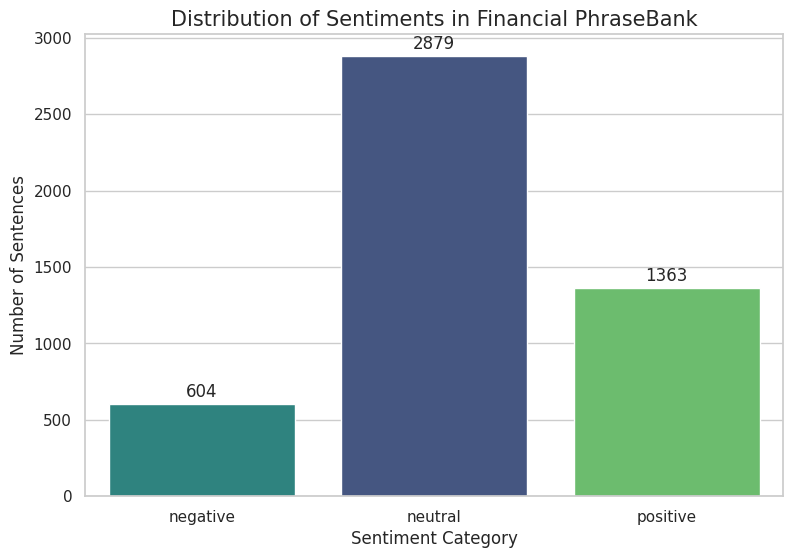

In [10]:
plt.figure(figsize=(9, 6))
sns.set_theme(style="whitegrid")

ax = sns.countplot(x='label', data=df, palette='viridis', order=['negative', 'neutral', 'positive'], hue='label', legend=False)

plt.title('Distribution of Sentiments in Financial PhraseBank', fontsize=15)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Sentences', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.show()

In [11]:
label_encoder = LabelEncoder() #turning labels to numbers
df['label_idx'] = label_encoder.fit_transform(df['label'])

class_names = label_encoder.classes_
print(f"Mapping: {dict(zip(range(len(class_names)), class_names))}")

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label_idx']
)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")

Mapping: {0: 'negative', 1: 'neutral', 2: 'positive'}
Train size: 3876, Validation size: 970


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

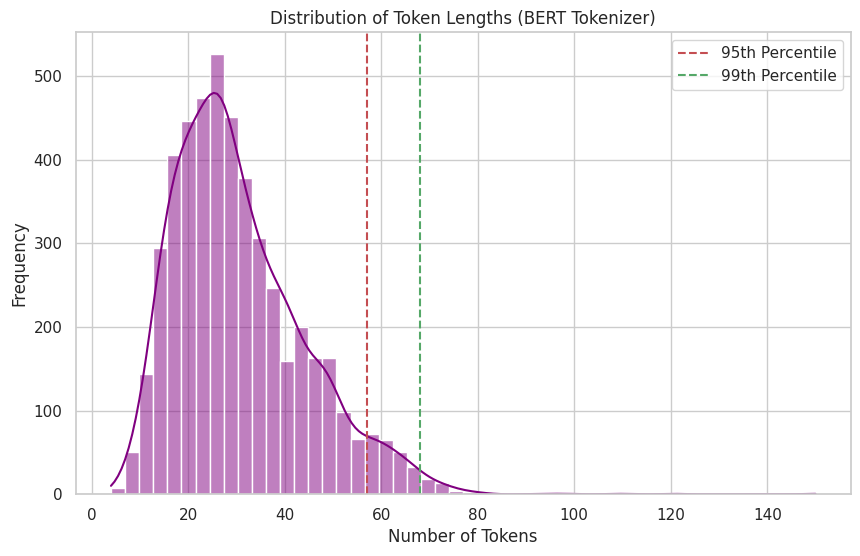

95% Percentile: 57.0
99% Percentile: 68.0
Max Length: 150


In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

df['token_lengths'] = [len(tokenizer.encode(s, add_special_tokens=True)) for s in df['sentence']]

plt.figure(figsize=(10, 6))
sns.histplot(df['token_lengths'], bins=50, kde=True, color='purple')
plt.title('Distribution of Token Lengths (BERT Tokenizer)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

plt.axvline(x=df['token_lengths'].quantile(0.95), color='r', linestyle='--', label='95th Percentile')
plt.axvline(x=df['token_lengths'].quantile(0.99), color='g', linestyle='--', label='99th Percentile')
plt.legend()
plt.show()

print(f"95% Percentile: {df['token_lengths'].quantile(0.95)}")
print(f"99% Percentile: {df['token_lengths'].quantile(0.99)}")
print(f"Max Length: {df['token_lengths'].max()}")

<font color=3C99D size=5>
Conclusion: </font>

Since only less than one percent of the sentences have more than 68 tokens, choosing 80 tokens as the max length is a good number



In [13]:
class FinancialDataset(Dataset):
    def __init__(self, sentences, labels, weights, tokenizer, max_len=80):
        self.sentences = sentences.values
        self.labels = labels.values
        self.weights = weights.values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, item):
        sentence = str(self.sentences[item])
        label = self.labels[item]
        weight = self.weights[item]

        encoding = self.tokenizer(
            sentence,
            add_special_tokens=True,  #Added [CLS], [SEP]
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long),
            'weights': torch.tensor(weight, dtype=torch.float)
        }

In [14]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_dataset = FinancialDataset(train_df['sentence'], train_df['label_idx'], train_df['weight'], tokenizer)
val_dataset = FinancialDataset(val_df['sentence'], val_df['label_idx'], val_df['weight'], tokenizer)

BATCH_SIZE = 16 #todo change to see the different results

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

sample_batch = next(iter(train_loader))
print(f"Input IDs shape: {sample_batch['input_ids'].shape}")
print(f"Attention Mask shape: {sample_batch['attention_mask'].shape}")

Input IDs shape: torch.Size([16, 80])
Attention Mask shape: torch.Size([16, 80])


# PART TWO

---

In [15]:

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        self.W_o = nn.Linear(d_model, d_model)
        self.last_attention_weights = None

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        Q = self.W_q(q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(k).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(v).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attn_weights = F.softmax(scores, dim=-1)
        self.last_attention_weights = attn_weights.detach().cpu()
        output = torch.matmul(attn_weights, V)

        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        return self.W_o(output)

In [16]:
class TransformerBlock(nn.Module):#Encoder only, as we need the whole thing for sentiment analysis and we don't need the masked multihead attention in decoder.
    def __init__(self, d_model, num_heads, ff_hidden_dim, dropout=0.3): #ff_hidden_dim can be increased in the case of underfitting
    # and decreased in the case of overfitting #todo ff_hidden_dim hyperparameter
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(ff_hidden_dim, d_model)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.attention.forward(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))

        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))

        return x

In [17]:
class FinancialTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, ff_hidden_dim, max_len, num_classes=3):
        super(FinancialTransformer, self).__init__()

        #these are learnable embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_len, d_model)

        self.layers = nn.ModuleList([
            TransformerBlock(d_model, num_heads, ff_hidden_dim)
            for _ in range(num_layers)
        ])

        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, input_ids, attention_mask):
        batch_size, seq_len = input_ids.shape

        #creating a list of numbers for each position and expanding it to every sentence and putting it on the same device as input_ids so we won't get an error.
        positions = torch.arange(0, seq_len).expand(batch_size, seq_len).to(input_ids.device)

        x = self.token_embedding(input_ids) + self.position_embedding(positions)
        x = self.dropout(x)

        mask = attention_mask.unsqueeze(1).unsqueeze(2)

        #Passing through all the encoder layers.
        for layer in self.layers:
            x = layer(x, mask)


        #The classifier expects a 2D tensor. So we only use the value for [CLS] which is the first token of every sentence as a summary for all the tokens of the sentence.
        cls_output = x[:, 0, :]

        #We are just using a linear mapping on the outputs and not a softmax. Later when we use nn.CrossEntropyLoss the softmax will be applied.
        #That is computationaly better as we won't have to deal with big or small numbers with some tricks.
        return self.fc(cls_output)

In [18]:
VOCAB_SIZE = tokenizer.vocab_size
D_MODEL = 512      #Hyperparameter  -> must be divisible by NUM_HEADS
NUM_HEADS = 8      #Hyperparameter
NUM_LAYERS = 4      #Hyperparameter
FF_HIDDEN_DIM = 2048  #Hyperparameter
MAX_LEN = 80          #Don't put it less than 68 and make it divisible by 8
NUM_CLASSES = 3

model = FinancialTransformer(
    vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    ff_hidden_dim=FF_HIDDEN_DIM,
    max_len=MAX_LEN,
    num_classes=NUM_CLASSES
)

print(model)

FinancialTransformer(
  (token_embedding): Embedding(30522, 512)
  (position_embedding): Embedding(80, 512)
  (layers): ModuleList(
    (0-3): 4 x TransformerBlock(
      (attention): MultiHeadAttention(
        (W_q): Linear(in_features=512, out_features=512, bias=True)
        (W_k): Linear(in_features=512, out_features=512, bias=True)
        (W_v): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=512, out_features=512, bias=True)
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): ReLU()
        (2): Linear(in_features=2048, out_features=512, bias=True)
      )
      (dropout): Dropout(p=0.3, inplace=False)
    )
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)


# PART THREE

---

In [19]:
criterion = nn.CrossEntropyLoss(reduction='none') #By setting reduction to none we are telling it not to give us the mean of the losses of the batches
#We want the loss for each one so we can multiply it by its corresponding weight.
optimizer = optim.Adam(model.parameters(), lr=1e-5)

<font color=DC143C size=6>
Warning </font>

Only set the train boolean in the cell below to True if you want to train and else set it to False. If you want to train it and use 20 epochs, set huge_epoch and train to True.

In [20]:
train = False
huge_epoch = False

In [21]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Device set to: Apple MPS (GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Device set to: NVIDIA CUDA (GPU)")
else:
    device = torch.device("cpu")
    print("Device set to: CPU")

if colab:
      path = '/content/drive/MyDrive/data/checkpoint.pth'
      huge_path = '/content/drive/MyDrive/data/checkpoint_huge.pth' #20 epochs tested for finding the best
else:
      path = 'checkpoint.pth'
      huge_path = 'checkpoint_huge.pth'



Device set to: NVIDIA CUDA (GPU)


In [22]:
def evaluate_model(model, data_loader):
    model.to(device)
    model.eval() # Sets layers like Dropout to off

    val_loss, val_correct = 0, 0

    with torch.no_grad(): # Stops memory use for gradients
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            val_loss += loss.mean().item()
            _, preds = torch.max(outputs, dim=1)
            val_correct += torch.sum(preds == labels)

    avg_loss = val_loss / len(data_loader)
    avg_acc = val_correct / len(data_loader.dataset)

    return avg_loss, avg_acc


In [23]:
def train_model(model, train_loader, val_loader, epochs=5):
    model.to(device)

    train_history = {'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}

    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0, 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            conf_weights = batch['weights'].to(device)

            #Each batch should be handled seperatly so we reset it for each of them.
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)

            losses = criterion(outputs, labels)
            loss = torch.mean(losses * conf_weights)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            total_correct += (preds == labels).sum().item() #We don't include the weights here as it makes it harder to explain

        avg_loss = total_loss / len(train_loader)
        avg_acc = total_correct / len(train_loader.dataset)

        train_history['loss'].append(avg_loss)
        train_history['acc'].append(avg_acc)

        v_loss, v_acc = evaluate_model(model, val_loader)
        train_history['val_loss'].append(v_loss)
        train_history['val_acc'].append(v_acc)
        if v_acc > best_val_acc:
            best_val_acc = v_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Acc: {avg_acc:.4f} | Val Loss: {v_loss:.4f} | Val Acc: {v_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return train_history



In [24]:
epochs = 20
if train and huge_epoch:
  history = train_model(model, train_loader, val_loader, epochs)

  checkpoint = {
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'history': history,
      'epoch': epochs
  }
  torch.save(checkpoint, huge_path)

In [25]:
if not huge_epoch:
  if os.path.exists(huge_path):
      checkpoint = torch.load(huge_path, map_location=device)

      model.load_state_dict(checkpoint['model_state_dict'])

      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

      history = checkpoint['history']

      model.to(device)
      print(f"Successfully loaded checkpoint from epoch {checkpoint['epoch']}")
  else:
      print("No checkpoint found. You need to train the model first.")
      history = train_model(model, train_loader, epochs)

      checkpoint = {
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'history': history,
          'epoch': epochs
      }
      torch.save(checkpoint, huge_path)

Successfully loaded checkpoint from epoch 20


In [26]:
def plot_results(history):
    epochs = range(1, len(history['loss']) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, [h.cpu() if torch.is_tensor(h) else h for h in history['loss']], 'b-', label='Train Loss')
    plt.plot(epochs, [h.cpu() if torch.is_tensor(h) else h for h in history['val_loss']], 'r-', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, [h.cpu() if torch.is_tensor(h) else h for h in history['acc']], 'b-', label='Train Acc')
    plt.plot(epochs, [h.cpu() if torch.is_tensor(h) else h for h in history['val_acc']], 'r-', label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend()

    plt.tight_layout()
    plt.show()

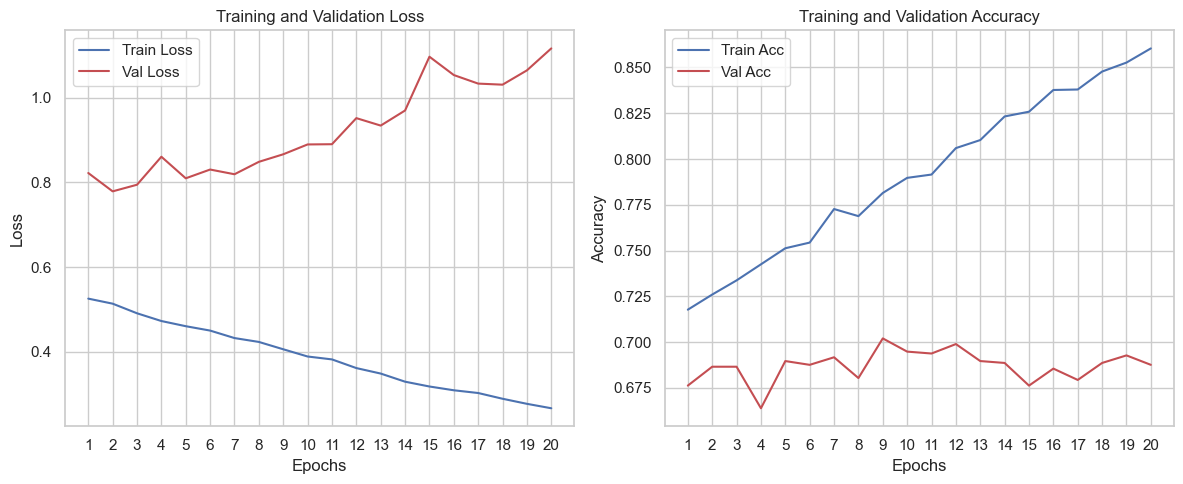

In [ ]:
plot_results(history)

<font color=3C99D size=5>
Conclusion: </font>

After ten epochs, the model starts to overfit and therefore, we won't train on more than 10 epochs.



In [27]:
epochs = 10 #Hyperparameter
if train:
  history = train_model(model, train_loader, val_loader, epochs)

  checkpoint = {
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'history': history,
      'epoch': epochs
  }
  torch.save(checkpoint, path)
else:
  if os.path.exists(path):
      checkpoint = torch.load(path, map_location=device)

      model.load_state_dict(checkpoint['model_state_dict'])

      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

      history = checkpoint['history']

      model.to(device)
      print(f"Successfully loaded checkpoint from epoch {checkpoint['epoch']}")
  else:
      print("No checkpoint found. You need to train the model first.")
      history = train_model(model, train_loader, epochs)

      checkpoint = {
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'history': history,
          'epoch': epochs
      }
      torch.save(checkpoint, path)

Successfully loaded checkpoint from epoch 10


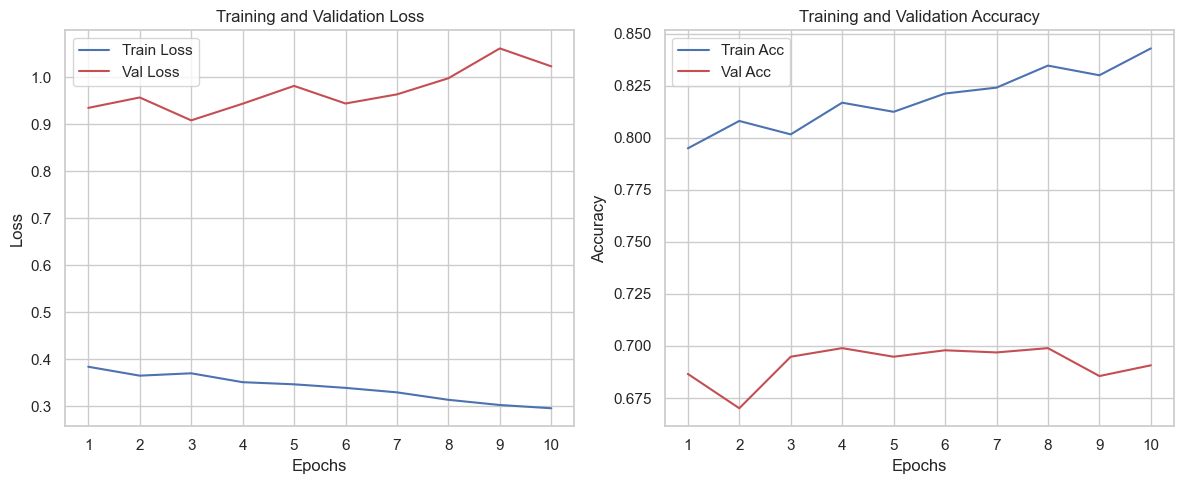

In [ ]:
plot_results(history)

# PART FOUR

---

Evaluation on Validation Set
Accuracy:  0.6990
Precision (weighted): 0.6861
Recall (weighted):    0.6990
F1-score (weighted):  0.6860

Classification Report:
              precision    recall  f1-score   support

    negative       0.64      0.45      0.52       121
     neutral       0.74      0.86      0.80       576
    positive       0.59      0.47      0.52       273

    accuracy                           0.70       970
   macro avg       0.66      0.59      0.61       970
weighted avg       0.69      0.70      0.69       970



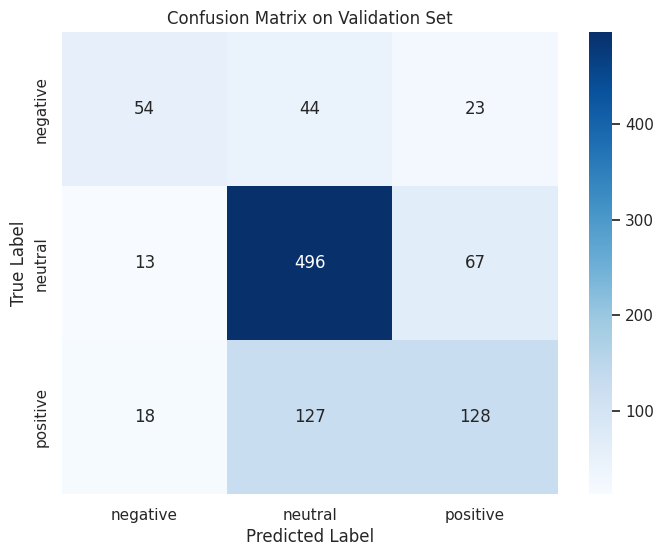


Per-class metrics:
negative   | Precision: 0.6353 | Recall: 0.4463 | F1: 0.5243
neutral    | Precision: 0.7436 | Recall: 0.8611 | F1: 0.7981
positive   | Precision: 0.5872 | Recall: 0.4689 | F1: 0.5214


In [28]:
# PART FOUR: Evaluation on Validation Set
# ----------------------------------------
# This part computes standard classification metrics and confusion matrix
# to evaluate the final model performance on the validation data.

import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Lists to store all predictions and true labels
all_preds = []
all_labels = []
all_probs = []   # optional: store probabilities if needed

# Disable gradient computation for efficiency
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)          # logits, shape (batch_size, num_classes)
        probs = torch.softmax(outputs, dim=1)               # probabilities (optional)
        preds = torch.argmax(outputs, dim=1)                # predicted class indices

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays for sklearn
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

print("Evaluation on Validation Set")
print("============================")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted):    {recall:.4f}")
print(f"F1-score (weighted):  {f1:.4f}")

# Detailed classification report (per class)
target_names = ['negative', 'neutral', 'positive']   # as defined earlier
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Validation Set')
plt.show()

# Optional: per-class metrics if needed
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
print("\nPer-class metrics:")
for i, name in enumerate(target_names):
    print(f"{name:10} | Precision: {precision_per_class[i]:.4f} | Recall: {recall_per_class[i]:.4f} | F1: {f1_per_class[i]:.4f}")

# PART FIVE

---

In [29]:
# PART FIVE (Adapted for Validation Set)
# ---------------------------------------
# This part runs the model on the validation set and saves predictions to a CSV file.
# Note: For the actual test submission, you'll need a similar loop but with a test DataLoader.

import pandas as pd
import torch
from tqdm import tqdm

model.eval()
all_val_preds = []
all_val_labels = []
all_val_sentences = []   # if you want to store the original sentences

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Predicting on validation set"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().numpy()   # true labels (already on CPU)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        all_val_preds.extend(preds)
        all_val_labels.extend(labels)

        # If you want to also save the sentences, you need to access them from the original val_df
        # Since val_loader doesn't directly give sentences, we need to map indices.
        # Alternatively, you can create a separate list of sentences from val_df beforehand.

# Since val_loader shuffles the data, to align sentences with predictions we should either:
# 1. Use a non-shuffled DataLoader for prediction (shuffle=False), or
# 2. Use the original val_df and rely on order (if DataLoader keeps order when shuffle=False).
# By default, your val_loader was created with shuffle=False (I assume), so order is preserved.

# Get the corresponding sentences from val_df
val_sentences = val_df['sentence'].values[:len(all_val_preds)]   # ensure same length

# Convert numeric labels back to original names
true_labels_names = label_encoder.inverse_transform(all_val_labels)
pred_labels_names = label_encoder.inverse_transform(all_val_preds)

# Create DataFrame
results_df = pd.DataFrame({
    'sentence': val_sentences,
    'true_label': true_labels_names,
    'predicted_label': pred_labels_names
})

# Save to CSV
results_df.to_csv('validation_predictions.csv', index=False)
print("Validation predictions saved to 'validation_predictions.csv'")
print(results_df.head())

Predicting on validation set: 100%|██████████| 61/61 [00:01<00:00, 48.93it/s]

Validation predictions saved to 'validation_predictions.csv'
                                            sentence true_label  \
0  Following the payment made in April , the comp...    neutral   
1  The share subscription period for C options wi...    neutral   
2  Aspocomp intends to set up a plant to manufact...    neutral   
3  Finnish Rautaruukki has been awarded a contrac...   positive   
4  Finnish Bank of +àland reports its operating p...   negative   

  predicted_label  
0         neutral  
1         neutral  
2        positive  
3        positive  
4        negative  


# PART SIX

---

In [30]:
num_samples = 5
sentences = val_df['sentence'].iloc[:num_samples].values
true_labels = val_df['label_idx'].iloc[:num_samples].values

model.eval()
attention_matrices = []   # to store the attention weight matrices

with torch.no_grad():
    for sent in sentences:
        # Tokenize the sentence (same max_len as training)
        encoding = tokenizer(
            sent,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(device)
        attn_mask = encoding['attention_mask'].to(device)

        # Forward pass (we don't need the output)
        _ = model(input_ids, attn_mask)

        # Retrieve attention weights from the last layer
        # shape: (1, num_heads, seq_len, seq_len)
        attn_weights = model.layers[-1].attention.last_attention_weights

        # Average over all heads → (seq_len, seq_len)
        avg_attn = attn_weights.mean(dim=1).squeeze(0).cpu().numpy()
        attention_matrices.append(avg_attn)

print(f"Extracted attention matrices for {len(attention_matrices)} sentences.")

Extracted attention matrices for 5 sentences.


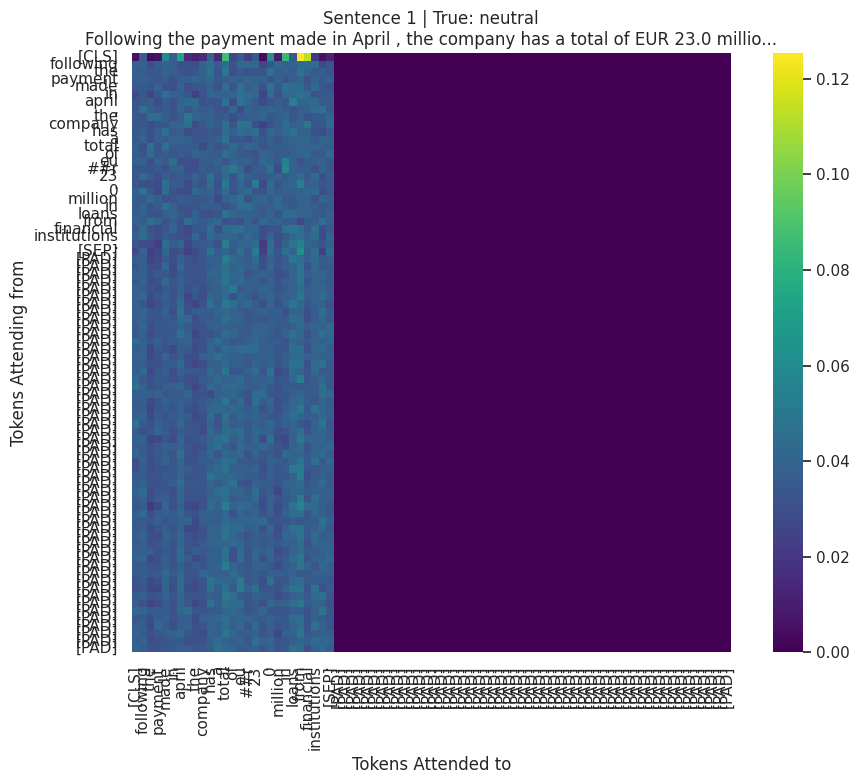

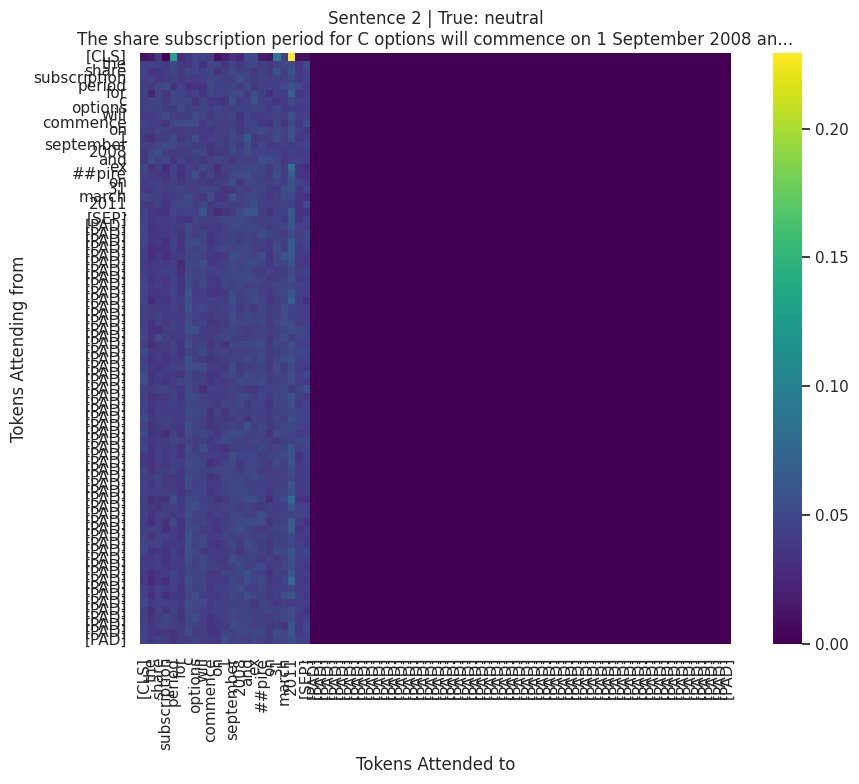

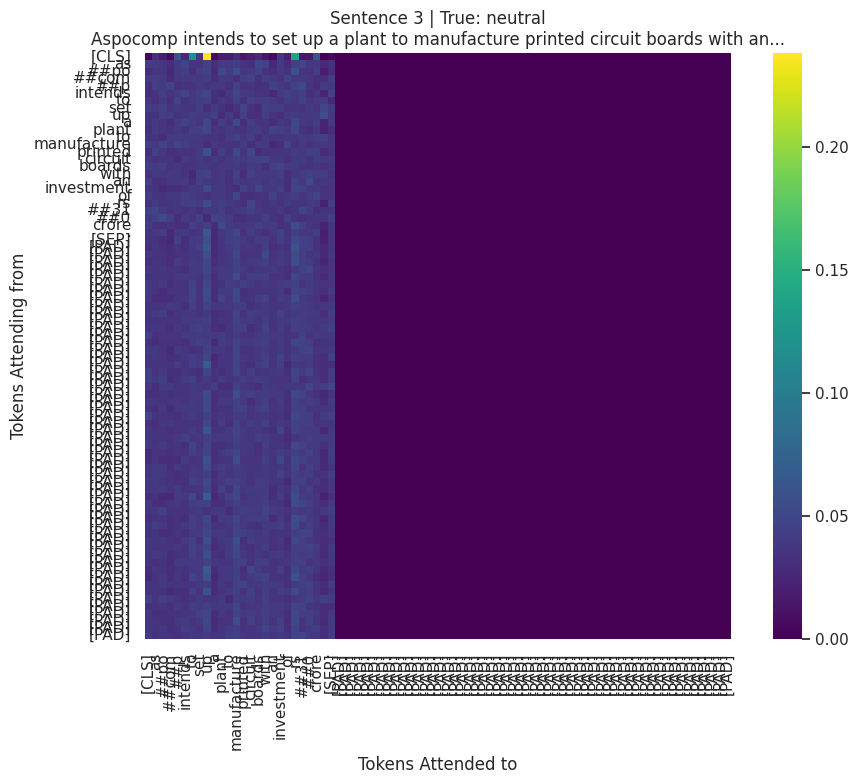

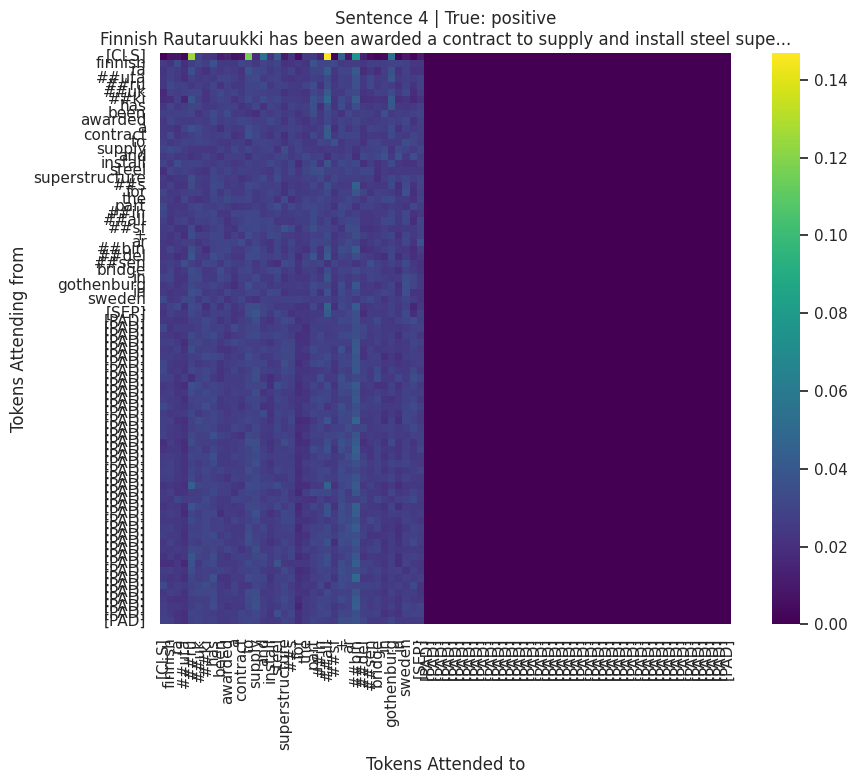

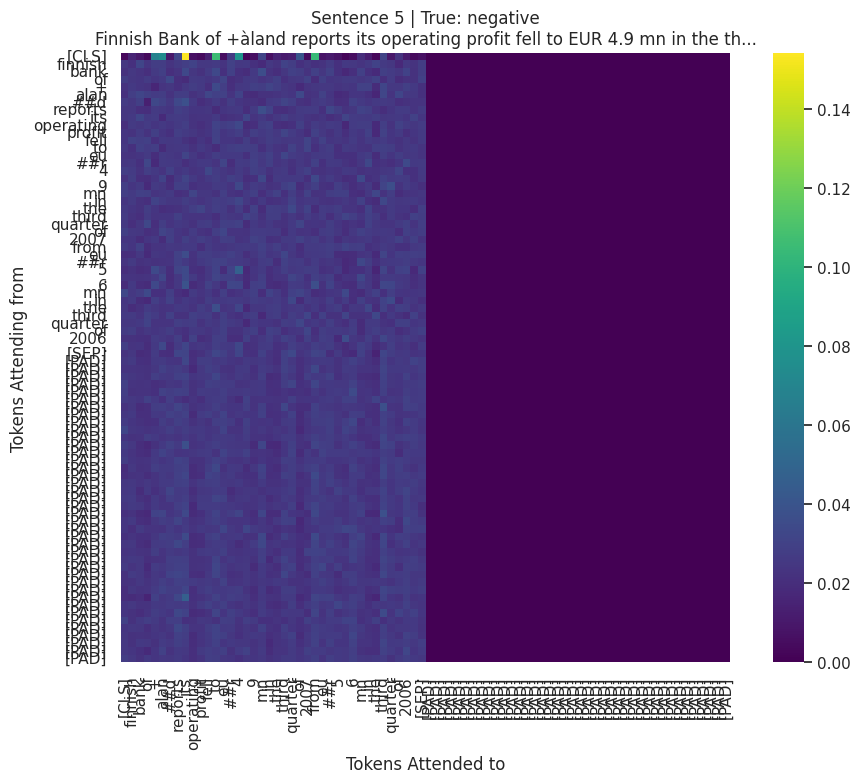

In [31]:
#Plot heatmaps with token labels
for i, (sent, attn_matrix) in enumerate(zip(sentences, attention_matrices)):
    # Tokenize again to get the actual tokens (including special tokens)
    tokens = tokenizer.tokenize(sent)
    # Add special tokens manually for alignment: BERT adds [CLS] at start and [SEP] at end
    tokens = ['[CLS]'] + tokens + ['[SEP]']
    # Truncate/pad to MAX_LEN (same as before)
    if len(tokens) > MAX_LEN:
        tokens = tokens[:MAX_LEN]
    else:
        tokens = tokens + ['[PAD]'] * (MAX_LEN - len(tokens))

    # True label name
    label_name = label_encoder.inverse_transform([true_labels[i]])[0]

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(attn_matrix, xticklabels=tokens, yticklabels=tokens,
                cmap='viridis', cbar=True, square=True)
    plt.title(f"Sentence {i+1} | True: {label_name}\n{sent[:80]}...")
    plt.xlabel("Tokens Attended to")
    plt.ylabel("Tokens Attending from")
    plt.tight_layout()
    plt.show()